In [13]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import generator_xy
import keras
import edward as ed
import numpy as np
from observations import mnist as mnist_obs
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
import pickle
import seaborn as sns
plt.style.use('ggplot')

In [2]:
sess = tf.InteractiveSession()
def load_data(path):
    f = open(path,'rb')
    return pickle.load(f)
def accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
        else:
            pass
    return correct/len(y_true)* 1.

In [3]:
x_train_AE = load_data('./data/encoded_train_AE.pkl')
x_test_AE = load_data('./data/encoded_test_AE.pkl')
x_train_BAE = load_data('./data/encoded_train_BAE.pkl')
x_test_BAE = load_data('./data/encoded_test_BAE.pkl')
(_, y_train), (_, y_test) = mnist_obs('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()

In [4]:
M = 10000
x_train_generator_AE = generator_xy([x_train_AE, y_train], M)
x_train_generator_BAE = generator_xy([x_train_BAE, y_train], M)

In [5]:
def NN_classifier(x, W_0, W_1, b_0, b_1):
    h = tf.nn.relu(tf.matmul(x,W_0) + b_0)
    h = tf.matmul(h,W_1) + b_1
    h = tf.nn.softmax(h)
    return h

In [6]:
W_0 = Normal(loc = tf.zeros([256, 100]), scale = tf.ones([256, 100]))
W_1 = Normal(loc = tf.zeros([100, 10]), scale = tf.ones([100,10]))
b_0 = Normal(loc = tf.zeros(100), scale = tf.ones(100))
b_1 = Normal(loc = tf.zeros(10), scale = tf.ones(10))

x = tf.placeholder(tf.float32, [None, 256])

y = Categorical(logits=NN_classifier(x, W_0, W_1, b_0, b_1))


In [7]:
qW_0 = Normal(loc = tf.Variable(tf.random_normal([256,100])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([256,100]))))
qW_1 = Normal(loc = tf.Variable(tf.random_normal([100,10])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([100,10]))))
qb_0 = Normal(loc = tf.Variable(tf.random_normal([100])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([100]))))
qb_1 = Normal(loc = tf.Variable(tf.random_normal([10])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([10]))))


In [8]:
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, data = {x: x_train_AE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [9]:
y_pred_train = NN_classifier(x_train_AE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = NN_classifier(x_test_AE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

0.12616666666666668
0.1359


In [10]:
n_epoch = 100
n_iter_per_epoch = x_train_AE.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch, y_batch = next(x_train_generator_AE)
    info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))

Epoch: 1
6/6 [100%] ██████████████████████████████ Elapsed: 2s
-log p(x) <= 16.189
Epoch: 2
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 15.463
Epoch: 3
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.820
Epoch: 4
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.473
Epoch: 5
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.224
Epoch: 6
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.084
Epoch: 7
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.973
Epoch: 8
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.886
Epoch: 9
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.813
Epoch: 10
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.765
Epoch: 11
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.721
Epoch: 12
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.736
E

6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 10.792
Epoch: 99
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 10.787
Epoch: 100
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 10.751


In [11]:
y_pred_train = NN_classifier(x_train_AE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = NN_classifier(x_test_AE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

0.7320166666666666
0.7383


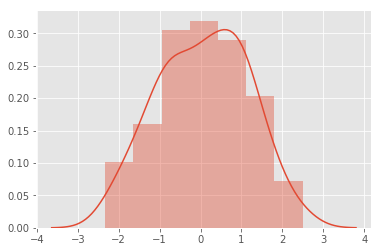

In [17]:
weights = qb_0.sample().eval()
sns.distplot(np.ndarray.flatten(weights))
plt.show()

In [8]:
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, data = {x: x_train_BAE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [9]:
y_pred_train = NN_classifier(x_train_BAE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = NN_classifier(x_test_BAE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

0.06931666666666667
0.1815


In [10]:
n_epoch = 100
n_iter_per_epoch = x_train_BAE.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch, y_batch = next(x_train_generator_BAE)
    info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))

Epoch: 1
6/6 [100%] ██████████████████████████████ Elapsed: 2s
-log p(x) <= 16.078
Epoch: 2
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.999
Epoch: 3
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.464
Epoch: 4
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 14.259
Epoch: 5
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.876
Epoch: 6
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.613
Epoch: 7
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.488
Epoch: 8
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.438
Epoch: 9
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.308
Epoch: 10
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.254
Epoch: 11
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.247
Epoch: 12
6/6 [100%] ██████████████████████████████ Elapsed: 3s
-log p(x) <= 13.152
E

In [11]:
y_pred_train = NN_classifier(x_train_BAE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = NN_classifier(x_test_BAE, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

0.72485
0.6963


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist_obs('./data')
y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
W_0 = Normal(loc = tf.zeros([28*28, 100]), scale = tf.ones([28*28, 100]))
W_1 = Normal(loc = tf.zeros([100, 10]), scale = tf.ones([100,10]))
b_0 = Normal(loc = tf.zeros(100), scale = tf.ones(100))
b_1 = Normal(loc = tf.zeros(10), scale = tf.ones(10))

x = tf.placeholder(tf.float32, [None, 28*28])

y = Categorical(logits=NN_classifier(x, W_0, W_1, b_0, b_1))

In [ ]:
qW_0 = Normal(loc = tf.Variable(tf.random_normal([28*28,100])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28,100]))))
qW_1 = Normal(loc = tf.Variable(tf.random_normal([100,10])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([100,10]))))
qb_0 = Normal(loc = tf.Variable(tf.random_normal([100])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([100]))))
qb_1 = Normal(loc = tf.Variable(tf.random_normal([10])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([10]))))


In [ ]:
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, data = {x: x_train, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [ ]:
y_pred_train = NN_classifier(x_train, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = NN_classifier(x_test, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

In [ ]:
y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)
x_train_generator = generator_xy([x_train, y_train.eval()], M)
n_epoch = 100
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch, y_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(-avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))

In [ ]:
y_pred_train = NN_classifier(x_train, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = NN_classifier(x_test, qW_0.sample(),qW_1.sample(),qb_0.sample(), qb_1.sample())
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))